In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

# Regression with ML

As final goodbye (or is it a final FU?) we will use machine learning for a regression task, trying to estimate the mice's running activity from ther phenotype data. Our target will no longer be binary (CD/HFD) or even categorical, but continuous valued.

To help you get started quickly, we have added a few lines of code to create the target vector, and deleted all running-related phenotype measurements from the input, such as night-time running activity.

In [20]:
pheno = pd.read_csv('../example_data/phenotype_cd_hfd.csv', index_col=0)
target = pheno['24hRun_ActivityWheel_[km]']

data = pheno.dropna(axis=1).drop(columns=['strain', '24hRun_ActivityWheel_[km]','DayRun_ActivityWheel_[km]','NightRun_ActivityWheel_[km]', 'Dist_post_[m]', 'Improvement_[meters]', 'Dist_pre_[m]'])
data['diet'] = data['diet'].replace('CD', 0).replace('HFD', 1)
data2 = (data - data.mean())/data.std()

Initialize a regressor, for example `SVR`. You can also use `RandomForestRegressor` or `KNeighborsRegressor`, they all have the same interface, and most code you write using them is interchangeable.

In [4]:
clf = SVR(C=1.0, epsilon=0.2)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Fit and predict all data. Plot the target and predicted vectors against each other using `plt.scatter`.

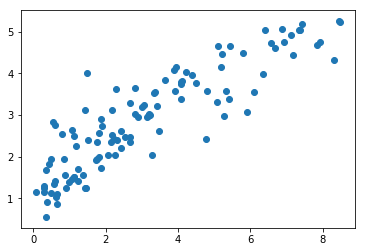

In [21]:
clf.fit(data2, target) 
predictions = clf.predict(data2)

plt.scatter(target, predictions)

Perform a cross-validated prediction. "Scoring" as such doesn't make much sense with continuous variables, so just use `cross_val_predict` and present them on a scatter plot against the target values, similar to above. Is it disappointing, satisfactory, or something in between?

Calculate the standard error as a measure of accuracy. It's a one liner: the standard deviation of difference between the predicted and the actual values.

1.8586929463707922

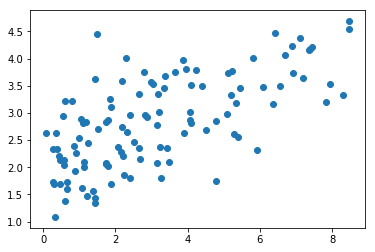

In [37]:
kf = KFold(n_splits=5, shuffle=True)
cv_val = cross_val_predict(clf, data2, target, cv=kf)

plt.scatter(target, cv_val)

# Standard error 
std_error = (cv_val - target)
np.sqrt(std_error.dot(std_error)/len(std_error))

What should we compare this performance to? A random predictor could, for example, return a random value from the available target values. Create a scatter plot of what that would be like. Hint: use `np.random.choice`, select a 100 random values twice, and plot them against each other. What is the average standard error for the random predictor?

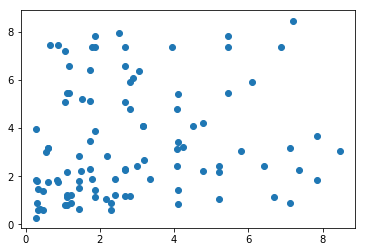

In [45]:
plt.scatter(np.random.choice(target,100), np.random.choice(target,100))

Use a `RandomForestRegressor` to do the task (use at least 100 trees though), and check the most important features. Do they make sense? Take the top 20, and evaluate models that use an increasing amount of them. Did you find a sweet spot?

0.5289022962226573

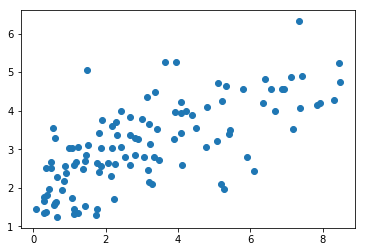

In [58]:
clf_rf = RandomForestRegressor(n_estimators=1000, max_depth=3, max_features=0.5)
clf_rf.fit(data2, target)

cv_probs_rf = cross_val_predict(clf_rf, data2, target, cv = KFold(3, shuffle=True))

plt.scatter(x = target,y = cv_probs_rf)

features = pd.DataFrame(clf_rf.feature_importances_, index = data.columns)

features = features.sort_values(0, ascending=False)
most_imp = features.nlargest(20, 0, keep='first')

cross_val_score(clf_rf, data2, target, cv = KFold(3, shuffle=True)).mean()

In [63]:
most_imp_ind = most_imp.index
most_imp_ind
# See
for i in range(1,20):
    cv_pred = cross_val_predict(clf_rf, data2.loc[:, most_imp_ind[:i]], target, cv = KFold(3, shuffle=True))
    print(i, (cv_pred-target).std())

1 1.8725271337019131
2 1.4393377933391678
3 1.5883844769330084
4 1.528347849533779
5 1.4975338670101481
6 1.4578915880285284
7 1.4672718082281853
8 1.5090579411070797
9 1.530622805661056
10 1.473694686772706
11 1.4872548050797556
12 1.4355370300818213
13 1.4570254858146525
14 1.463018461067698
15 1.5850872910192597
16 1.5358124578940422
17 1.538189058035508
18 1.4835162522858032
19 1.5302928492905223
